## Reproduce the results of Figure 8

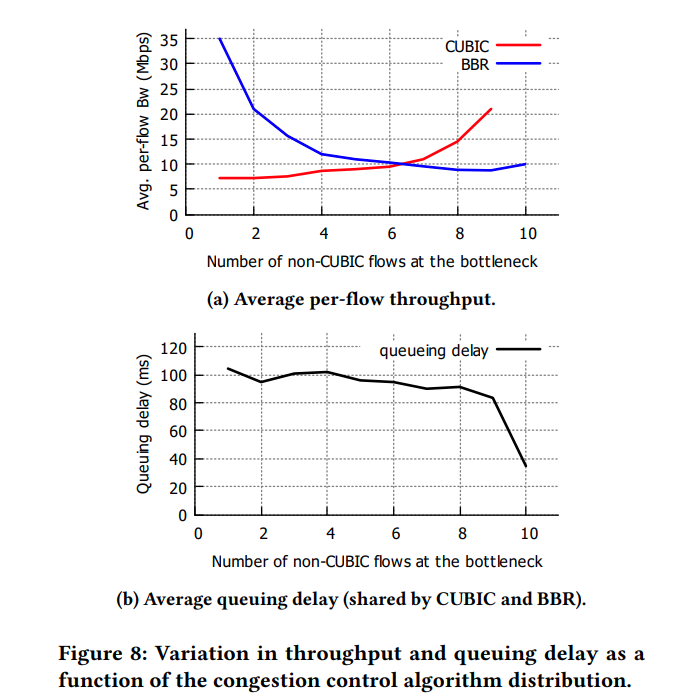

## Prepare a line network

In [28]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,ashusri_0000051121
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,ashusri_0000051121
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


In [29]:
!chmod 600 /home/fabric/work/fabric_config/fabric_bastion_key
!chmod 600 /home/fabric/work/fabric_config/slice_key

### Get resources

In [30]:
slice_name="bbr-dominance-line"

if fablib.get_slice(slice_name):
    print("You already have a slice named %s - skip the next part." % slice_name)
    slice = fablib.get_slice(name=slice_name)
    print(slice)

You already have a slice named bbr-dominance-line - skip the next part.
-----------  ------------------------------------
Slice Name   bbr-dominance-line
Slice ID     ab70650e-13c1-441e-afdb-442d6f451063
Slice State  StableOK
Lease End    2024-03-23 18:34:00 +0000
-----------  ------------------------------------


In [4]:
slice_name="bbr-dominance-line"
slice = fablib.get_slice(slice_name)

Exception: Unable to find slice "bbr-dominance-line" for this project. Check slice name spelling and project id.

Find out about available resources:

In [5]:
try:
    print(f"{fablib.list_sites()}")
except Exception as e:
    print(f"Exception: {e}")

Name,State,Address,Location,PTP Capable,Hosts,CPUs,Cores Available,Cores Capacity,Cores Allocated,RAM Available,RAM Capacity,RAM Allocated,Disk Available,Disk Capacity,Disk Allocated,Basic NIC Available,Basic NIC Capacity,Basic NIC Allocated,ConnectX-6 Available,ConnectX-6 Capacity,ConnectX-6 Allocated,ConnectX-5 Available,ConnectX-5 Capacity,ConnectX-5 Allocated,NVMe Available,NVMe Capacity,NVMe Allocated,Tesla T4 Available,Tesla T4 Capacity,Tesla T4 Allocated,RTX6000 Available,RTX6000 Capacity,RTX6000 Allocated,A30 Available,A30 Capacity,A30 Allocated,A40 Available,A40 Capacity,A40 Allocated,U280 Available,U280 Capacity,U280 Allocated
MICH,Active,"2530 Draper Dr,Ann Arbor, MI 48109","(0, 0)",True,3,6,308,384,76,1368,1506,138,63411,64161,750,348,381,33,2,2,0,2,2,0,10,10,0,2,2,0,3,3,0,0,0,0,0,0,0,0,1,1
STAR,Active,"710 North Lakeshore Drive, 60611","(0, 0)",True,6,12,460,768,308,2514,3012,498,106936,109696,2760,711,762,51,1,2,1,6,6,0,19,20,1,4,6,2,6,6,0,0,0,0,0,0,0,0,1,1
SALT,Active,"572 Delong Street,Salt Lake City, UT 84104","(0, 0)",False,3,6,284,384,100,1330,1506,176,62701,64161,1460,368,381,13,2,2,0,2,2,0,10,10,0,2,2,0,3,3,0,0,0,0,0,0,0,0,1,1
GATECH,Active,"760 West Peachtree Street NW,Atlanta, GA 30308","(0, 0)",True,5,10,486,640,154,2244,2510,266,57519,58849,1330,584,635,51,0,2,2,4,4,0,16,16,0,0,0,0,0,0,0,7,7,0,0,0,0,0,1,1
NCSA,Active,"1725 S Oak St.,Champaign, IL 61820","(0, 0)",True,3,6,322,384,62,1354,1506,152,63321,64161,840,360,381,21,1,2,1,2,2,0,10,10,0,2,2,0,3,3,0,0,0,0,0,0,0,0,1,1
WASH,Active,"1755 Old Meadow Road, 22102","(0, 0)",False,3,6,294,384,90,1206,1506,300,62701,64161,1460,264,381,117,2,2,0,2,2,0,10,10,0,2,2,0,3,3,0,0,0,0,0,0,0,0,1,1
MAX,Active,"4161 Fieldhouse Drive,College Park,MD 20742","(0, 0)",True,5,10,388,640,252,1688,2510,822,105330,107463,2133,574,635,61,2,2,0,4,4,0,16,16,0,4,4,0,1,6,5,0,0,0,0,0,0,0,1,1
RUTG,Active,"120 Avenue E,Piscataway,New Jersey 08854","(0, 0)",True,5,10,581,640,59,2350,2510,160,106063,107463,1400,605,635,30,2,2,0,4,4,0,15,16,1,0,0,0,0,0,0,7,8,1,0,0,0,0,1,1
SRI,Active,"333 Ravenswood Avenue,Menlo Park, CA 94025","(0, 0)",True,3,6,366,384,18,1434,1506,72,55988,56618,630,372,381,9,2,2,0,2,2,0,10,10,0,0,0,0,0,0,0,4,4,0,0,0,0,1,1,0
EDUKY,Active,"301 Hilltop Avenue,Lexington, KY 40506","(0, 0)",True,18,36,73653,73728,75,8778,9036,258,133662,134082,420,4399,4445,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Pick a random site and show it. Re-run if you don't like the selection:

In [6]:
site_name = fablib.get_random_site()
site_name

'CLEM'

In [7]:
slice = fablib.new_slice(name=slice_name)

In [8]:
node_names = ["client", "emulator", "router", "server"]
for n in node_names:
    slice.add_node(name=n, site=site_name, cores=4, ram=32, disk=100, image='default_ubuntu_20')

In [9]:
nets = [
    {"name": "client-em",   "nodes": ["client", "emulator"]},
    {"name": "em-rtr",      "nodes": ["emulator", "router"]},
    {"name": "rtr-server",  "nodes": ["router", "server"]},
]

In [10]:
for n in nets:
    ifaces = [slice.get_node(node).add_component(model="NIC_Basic", name=n["name"]+"_" + node).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

In [11]:
slice.submit()


Retry: 13, Time: 428 sec


ID,ab70650e-13c1-441e-afdb-442d6f451063
Name,bbr-dominance-line
Lease Expiration (UTC),2024-03-20 18:12:28 +0000
Lease Start (UTC),2024-03-19 18:12:29 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
55c31a1e-0894-440e-8873-207559dc5ffe,client,4,32,100,default_ubuntu_20,qcow2,clem-w3.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fe18:998a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe18:998a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
7f5bbcb5-3bc4-4738-8b51-a1658ce39d2f,emulator,4,32,100,default_ubuntu_20,qcow2,clem-w3.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fecf:ef7c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fecf:ef7c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
55c9d0c9-90f2-4eac-9c16-700096b8d31c,router,4,32,100,default_ubuntu_20,qcow2,clem-w3.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fe95:459e,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe95:459e,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
bf83aa11-fe38-4675-b987-3ac838982437,server,4,32,100,default_ubuntu_20,qcow2,clem-w3.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fe17:a2c2,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe17:a2c2,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
e53b8916-a78c-48bd-a4b8-29063ed3e6fd,client-em,L2,L2Bridge,CLEM,None,None,Active,
bc4e097b-5a39-476d-9cd1-15bbfd6defcb,em-rtr,L2,L2Bridge,CLEM,None,None,Active,
4d5a51e4-2ece-417d-9ec8-88bdf0b03c68,rtr-server,L2,L2Bridge,CLEM,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
client-client-em_client-p1,p1,client,client-em,100,config,,5E:41:6F:27:9C:53,enp6s0,enp6s0,None,4
emulator-client-em_emulator-p1,p1,emulator,client-em,100,config,,66:40:B6:E2:2A:29,enp6s0,enp6s0,None,4
emulator-em-rtr_emulator-p1,p1,emulator,em-rtr,100,config,,72:18:99:06:84:8E,enp7s0,enp7s0,None,4
router-em-rtr_router-p1,p1,router,em-rtr,100,config,,62:62:53:F6:0B:8F,enp7s0,enp7s0,None,4
router-rtr-server_router-p1,p1,router,rtr-server,100,config,,5E:52:97:6D:E8:56,enp6s0,enp6s0,None,4
server-rtr-server_server-p1,p1,server,rtr-server,100,config,,72:27:32:D6:DA:5D,enp6s0,enp6s0,None,4



Time to print interfaces 437 seconds


'ab70650e-13c1-441e-afdb-442d6f451063'

In [12]:
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

In [13]:
for node in slice.get_nodes():
    print(f"{node}")

-----------------  ------------------------------------------------------------------------------------------------------------------------------------------
ID                 55c31a1e-0894-440e-8873-207559dc5ffe
Name               client
Cores              4
RAM                32
Disk               100
Image              default_ubuntu_20
Image Type         qcow2
Host               clem-w3.fabric-testbed.net
Site               CLEM
Management IP      2620:103:a006:12:f816:3eff:fe18:998a
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe18:998a
-----------------  ------------------------------------------------------------------------------------------------------------------------------------------
-----------------  -----------------------------------------------------------------------------------------------------------------------------------

### Set up the line topology

### Configure addresses

In [14]:
if_conf = {
    "client-client-em_client-p1":     {"addr": "10.0.1.1", "subnet": "10.0.1.0/24"},
    "emulator-client-em_emulator-p1": {"addr": "10.0.1.2", "subnet": "10.0.1.0/24"},
    "emulator-em-rtr_emulator-p1":    {"addr": "10.0.2.1", "subnet": "10.0.2.0/24"},
    "router-em-rtr_router-p1":        {"addr": "10.0.2.2", "subnet": "10.0.2.0/24"},
    "router-rtr-server_router-p1":    {"addr": "10.0.3.2", "subnet": "10.0.3.0/24"},
    "server-rtr-server_server-p1":    {"addr": "10.0.3.1", "subnet": "10.0.3.0/24"}
}

In [15]:
from ipaddress import ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network
for iface in slice.get_interfaces():
    if_name = iface.get_name()
    iface.ip_addr_add(addr=if_conf[if_name]['addr'], subnet=IPv4Network(if_conf[if_name]['subnet']))

In [16]:
for iface in slice.get_interfaces():
    iface.ip_link_up()

In [17]:
rt_conf = [
    {"name": "client",   "addr": "10.0.3.0/24", "gw": "10.0.1.2"},
    {"name": "emulator", "addr": "10.0.3.0/24", "gw": "10.0.2.2"},
    {"name": "router",   "addr": "10.0.1.0/24", "gw": "10.0.2.1"},
    {"name": "server",   "addr": "10.0.1.0/24", "gw": "10.0.3.2"}
]

In [18]:
for rt in rt_conf:
    slice.get_node(name=rt['name']).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

In [19]:
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


### Install stuff

In [20]:
apt_inst = [
    {"name": "client",  "packages": ["iperf3", "moreutils"]},
    {"name": "router",  "packages": ["moreutils","jq"]},
    {"name": "server",  "packages": ["iperf3", "moreutils"]},
]

In [21]:
for a in apt_inst:
    slice.get_node(name=a['name']).execute("sudo apt update")
    slice.get_node(name=a['name']).execute("sudo apt -y install " + " ".join(a['packages']))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
 

 Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2804 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:9 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://nova.clouds.archive.ubun

#### Renew slice if needed

In [22]:
import datetime
from datetime import timedelta

now = datetime.datetime.now(datetime.timezone.utc)
end_date = (now + timedelta(days=4)).strftime("%Y-%m-%d %H:%M:%S %z")

slice.renew(end_date)

### Experiment configuration

In [23]:
btl_capacity = 100 # mbit
base_owd     = 20  # ms, to be applied in each direction
n_bdp        = 2
btl_limit    = int(1000*n_bdp*btl_capacity*2*base_owd/8)

### Configure network

Set up bottleneck at router:

In [24]:
btl = [
    {"name": "router", "if": "router-rtr-server_router-p1"}
]    
for b in btl:
    os_if_name = slice.get_interface(name=b['if']).get_os_interface()
    cmds = '''
    sudo tc qdisc del dev {iface} root
    sudo tc qdisc replace dev {iface} root handle 1: htb default 3 
    sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {capacity}mbit 
    sudo tc qdisc add dev {iface} parent 1:3 handle 3: bfifo limit {buffer} 
    '''.format(iface=os_if_name, capacity=btl_capacity, buffer=btl_limit)
    slice.get_node(name=b["name"]).execute(cmds)

 Error: Cannot delete qdisc with handle of zero.
 

Set up delay at emulator:

In [25]:
em = [
    {"name": "emulator", "if": "emulator-client-em_emulator-p1"},
    {"name": "emulator", "if": "emulator-em-rtr_emulator-p1"}
]    
for e in em:
    os_if_name = slice.get_interface(name=e['if']).get_os_interface()
    cmds = "sudo tc qdisc replace dev {iface} root netem delay {owd}ms limit 60000".format(iface=os_if_name, owd=base_owd, buffer=btl_limit)
    slice.get_node(name=e["name"]).execute(cmds)

In [26]:
slice.get_node(name="client").execute("sudo modprobe tcp_bbr")

('', '')

### Iterate over number of BBR flows

In [27]:
import time

d = 200
slice.get_node(name="server").execute("killall iperf3")
os_if_name = slice.get_interface(name="router-rtr-server_router-p1").get_os_interface()
router_script="rm queue-{expid}.txt; start_time=$(date +%s); while true; do tc -p -s -d qdisc show dev {iface} | tr -d '\n' | ts '%.s' | tee -a queue-{expid}.txt; echo "" | tee -a queue-{expid}.txt; current_time=$(date +%s); elapsed_time=$((current_time - start_time));  if [ $elapsed_time -ge {duration} ]; then break; fi; sleep 0.1; done;"

ss_script="rm -f {expid}-ss.txt; start_time=$(date +%s); while true; do ss --no-header -eipn dst 10.0.3.1 | ts '%.s' | tee -a {expid}-ss.txt; current_time=$(date +%s); elapsed_time=$((current_time - start_time));  if [ $elapsed_time -ge {duration} ]; then break; fi; sleep 0.1; done;"


for i in range(1, 11):
    print("Staring experiment with {flows} BBR flows, for {duration} seconds".format(flows=i, duration=d))
    # start BBR and non-BBR server instance
    slice.get_node(name="server").execute("iperf3 -s -1 -p 4000 -D")
    slice.get_node(name="server").execute("iperf3 -s -1 -p 5000 -D")
    slice.get_node(name="router").execute_thread(router_script.format(expid=i, iface=os_if_name, duration=d))
    slice.get_node(name="client").execute_thread(ss_script.format(expid=i, duration=d))
    slice.get_node(name="client").execute_thread("sleep 1; iperf3 -c 10.0.3.1 -t {duration} -P {flows} -C bbr -p 4000 -J > bbr-result-{expid}.json".format(duration=d, flows=i, expid=i))
    stdout, stderr = slice.get_node(name="client").execute("sleep 1; iperf3 -c 10.0.3.1 -t {duration} -P {flows} -C cubic -p 5000 -i 0.1 -J > cubic-result-{expid}.json".format(duration=d, flows=10-i, expid=i))
    time.sleep(5)
    


 iperf3: no process found
 Staring experiment with 1 BBR flows, for 200 seconds
Staring experiment with 2 BBR flows, for 200 seconds
Staring experiment with 3 BBR flows, for 200 seconds
Staring experiment with 4 BBR flows, for 200 seconds
Staring experiment with 5 BBR flows, for 200 seconds
Staring experiment with 6 BBR flows, for 200 seconds
Staring experiment with 7 BBR flows, for 200 seconds
Staring experiment with 8 BBR flows, for 200 seconds
Staring experiment with 9 BBR flows, for 200 seconds
Staring experiment with 10 BBR flows, for 200 seconds


#### Download experiment data from the FABRIC nodes to your local directory on JupyterHub

In [39]:
import shutil
shutil.rmtree("figure_8_results")

In [41]:
import os

os.makedirs("figure_8_results/100Mbps,40ms")

In [35]:
for i in range(1, 11):
    
    slice.get_node(name="client").download_file("/home/fabric/work/bbr-dominance-experiments/figure_8_results/100Mbps,40ms/bbr-result-{expid}.json".format(expid=i),"/home/ubuntu/bbr-result-{expid}.json".format(expid=i))
    slice.get_node(name="client").download_file("/home/fabric/work/bbr-dominance-experiments/figure_8_results/100Mbps,40ms/cubic-result-{expid}.json".format(expid=i),"/home/ubuntu/cubic-result-{expid}.json".format(expid=i))
    slice.get_node(name="router").download_file("/home/fabric/work/bbr-dominance-experiments/figure_8_results/100Mbps,40ms/queue-{expid}.txt".format(expid=i),"/home/ubuntu/queue-{expid}.txt".format(expid=i))
    slice.get_node(name="router").execute("cat queue-{expid}.txt | awk '{{print $1\",\"$24$30\",\"$31}}' | tr -d 'b' | tr -d 'p' | sed 's/K/000/' | sed 's/M/000000/' > queue-{expid}.csv".format(expid=i))
    slice.get_node(name="router").download_file("/home/fabric/work/bbr-dominance-experiments/figure_8_results/100Mbps,40ms/queue-{expid}.csv".format(expid=i),"/home/ubuntu/queue-{expid}.csv".format(expid=i))

### Analyze data and generate plot

1
2
3
4
5
6
7
8
9


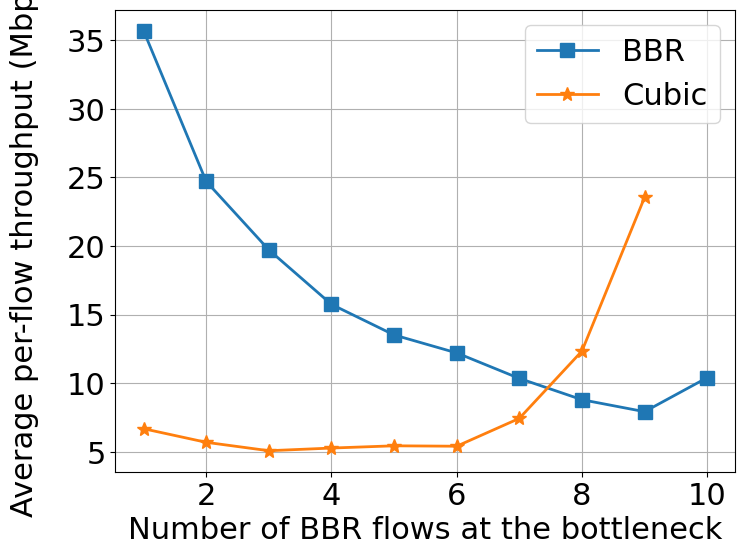

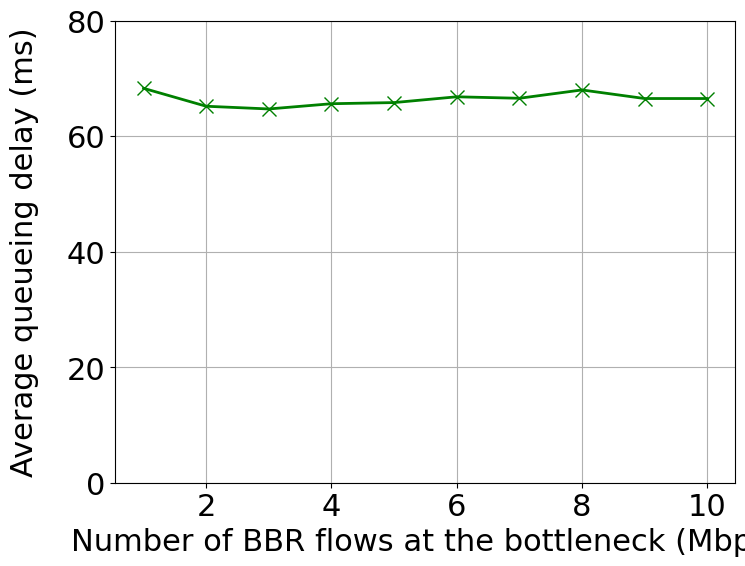

In [36]:
btl_capacity = 100 # mbit
base_owd     = 20  # ms, to be applied in each direction
n_bdp        = 2
btl_limit    = int(1000*n_bdp*btl_capacity*2*base_owd/8)

import json

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

scenario ='100Mbps,40ms' # specify network scenario

per_flow_throughput_bbr = np.zeros(10)
per_flow_throughput_cubic = np.zeros(9)
average_queue_delay = np.zeros(10)


for i in range(1,10):
    # Load the JSON output file into a Python object
    with open("figure_8_results/{scenario}/bbr-result-{expid}.json".format(expid=i, scenario=scenario), "r") as f:
        iperf3_data = json.load(f)


    per_flow_throughput_bbr[i-1] = iperf3_data['end']['sum_received']['bits_per_second']/(1000000*i)
    #print(f"per_flow_throughput_bbr-{i}: {iperf3_data['end']['sum_received']['bits_per_second']/(1000000*i)} Mbps")
    
    with open("figure_8_results/{scenario}/cubic-result-{expid}.json".format(expid=i, scenario=scenario), "r") as f:
        iperf3_data = json.load(f)
    #print(f"per_flow_throughput_cubic-{i}: {iperf3_data['end']['sum_received']['bits_per_second']/(1000000*i)} Mbps")

    per_flow_throughput_cubic[i-1] = iperf3_data['end']['sum_received']['bits_per_second']/(1000000*(10-i))
    
    print(i)
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv("figure_8_results/{scenario}/queue-{expid}.csv".format(expid=i, scenario=scenario), header=None, names=["timestamp", "c2","backlog","c4"])

    average_queue_delay[i-1] = (df["backlog"].mean()*8)/(btl_capacity*1000)
    
with open("figure_8_results/{scenario}/bbr-result-{expid}.json".format(expid=10, scenario=scenario), "r") as f:
     iperf3_data = json.load(f)


per_flow_throughput_bbr[i] = iperf3_data['end']['sum_received']['bits_per_second']/(1000000*i)

df = pd.read_csv("figure_8_results/{scenario}/queue-{expid}.csv".format(expid=i, scenario=scenario), header=None, names=["timestamp", "c2","backlog","c4"])

average_queue_delay[i] = (df["backlog"].mean()*8)/(btl_capacity*1000)

plt.rcParams.update({'font.size': 22})

fontsize=22

linewidth=2.0

labelsize=22

markersize = 10


x1 = np.arange(1, 11)
x2 = np.arange(1, 10)
# Create the figure with a specific size
fig, ax = plt.subplots(figsize=(8,6))

# Plot the data
ax.plot(x1, per_flow_throughput_bbr, label='BBR', linewidth=linewidth, marker ='s', markersize=10)
ax.plot(x2, per_flow_throughput_cubic, label='Cubic', linewidth=linewidth, marker ='*', markersize=10)

# Set the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=labelsize)

# Set the x-axis and y-axis labels
ax.set_xlabel('Number of BBR flows at the bottleneck', fontsize=fontsize)
ax.set_ylabel('Average per-flow throughput (Mbps)', fontsize=fontsize, labelpad=20)

# Leave a gap between the y-axis label and the tick labels
#ax.yaxis.set_label_coords(-0.1, 0.5, transform=ax.transAxes, labelpad=20)

# Add a legend
ax.legend(fontsize=fontsize)

# Add grid lines
ax.grid()


plt.savefig('figure_8a.pdf')


# Create the figure with a specific size
fig, ax = plt.subplots(figsize=(8,6))

x1 = np.arange(1, 11)
ax.plot(x1, average_queue_delay, linewidth=linewidth, marker ='x', markersize=10, color = "green",  )
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_xlabel('Number of BBR flows at the bottleneck (Mbps)', fontsize=fontsize)
ax.set_ylabel('Average queueing delay (ms)', fontsize=fontsize,  labelpad=20)
plt.ylim(0, 80)
ax.grid()


plt.savefig('figure_8b.pdf')